# 1. Build A LDA Model of 2012 London Olympics

## 1.1 Packages Importing

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet  import WordNetLemmatizer
from nltk import FreqDist
import pandas as pd
import numpy as py
import string
from gensim.models import CoherenceModel, LdaModel, LdaMulticore, Phrases, TfidfModel
from gensim.corpora import Dictionary
from gensim.models.phrases import Phraser
# libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## 1.2 Parameters Setting 

In [391]:
col = 2                             # Define which columns are used for topic modelling.
coherence_type = 'c_v'       # Define coherence type
min_len = 4                       # Define the short word length
no_below =  2                   #a threshold filtering out number of occurrence of the tokens among documents  no larger than 5
no_above = 0.9                 #the portion of a word in total corpus size
chunksize = 2000              #Number of documents to be used in each training chunk
eval_every = None             # Don't evaluate model perplexity, takes too much time.
num_topics =  20              #The number of requested latent topics to be extracted from the training corpus.
num_passes = 20              #Number of passes through the corpus during training
iterations = 100                #Maximum number of iterations through the corpus when inferring the topic distribution of a corpus.
alpha = 50.0/num_topics   #expresses our a-priori belief for each topics’ probability
#eta = 'auto'     
eta =      0.01                  #A-priori belief on word probability
random_state  = 54321     #Either a randomState object or a seed to generate one. Useful for reproducibility.
lemmatization = 1             #Whether implement corpus lemmatization 2:Lemmatizer (without POS tags) 1:Lemmatizer (with POS tags) 0:no

## 1.3 Corpus Reading 

In [20]:
df = pd.read_csv("Olympics-ALL-DOCS.csv", header = None, error_bad_lines=False)

In [28]:
df[2]

0       Examination of Witnesses   SEPTEMBER   MS BAR...
1       Examination of Witnesses   SEPTEMBER   MS BAR...
2       Examination of Witnesses   SEPTEMBER   MS BAR...
3       Select Committee on Culture Media and Sport M...
4       Select Committee on Culture Media and Sport M...
                             ...                        
164     London  Olympics and Paralympic Games Written...
165     London  Olympic and Paralympic Games Written ...
166     London  Olympics and Paralympic Games Written...
167     REPORT BY THE COMPTROLLER AND AUDITOR GENERAL...
168     House of Commons Committee of Public Accounts...
Name: 2, Length: 169, dtype: object

## 1.4 Data Processing

Document number: 169


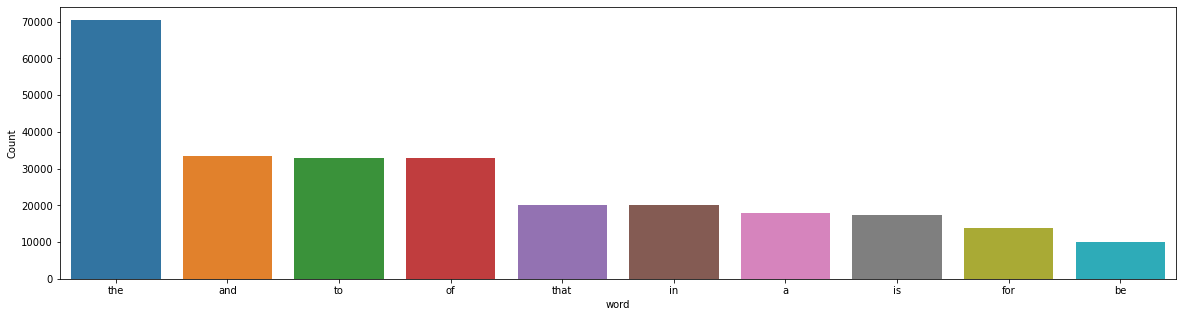

In [27]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join(['%s' %text for text in x])
    all_words = all_words.split()
    
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

print('Document number: %d'% (len(df[col])))
freq_words(df[2],10) 

<ipython-input-29-03fde7e31d6c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = df[col][i].lower()
<ipython-input-29-03fde7e31d6c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = tokenizer.tokenize(df[col][i])


Tokens number: 19221


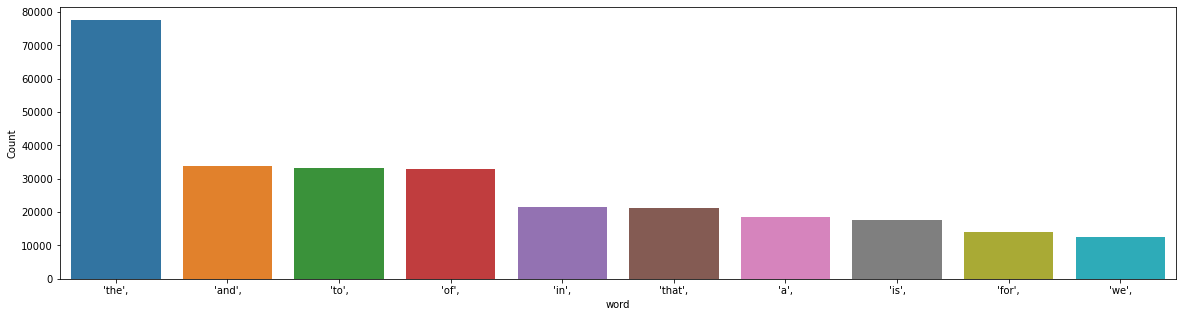

In [29]:
#Tokenize the corpus 
tokenizer = RegexpTokenizer(r'\w+')
for i in range (len(df)):
    df[col][i] = df[col][i].lower()
    df[col][i] = tokenizer.tokenize(df[col][i])

print('Tokens number: %d'% (len(Dictionary(df[col]))))
freq_words(df[col],10) 

Tokens number after removing number: 19221


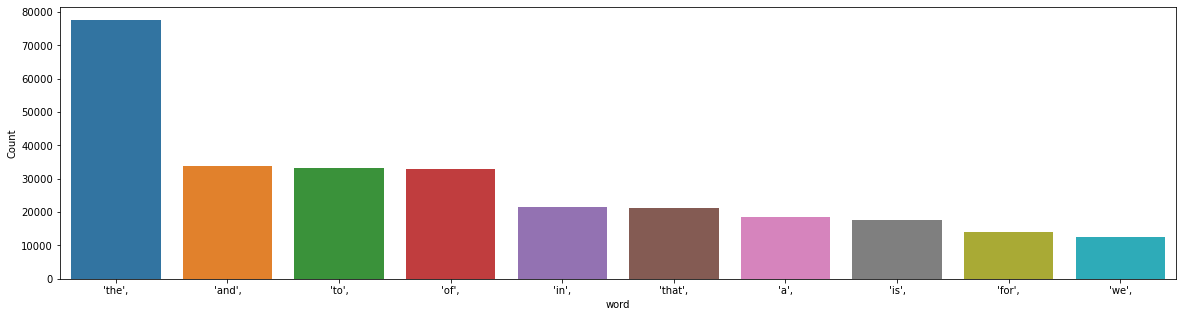

In [30]:
#Remove the number
df[col] = [ [token for token in doc if not token.isnumeric()] for doc in df[col]]

print('Tokens number after removing number: %d'% (len(Dictionary(df[col]))))
freq_words(df[col],10) 

Tokens number after removing stop words: 19085


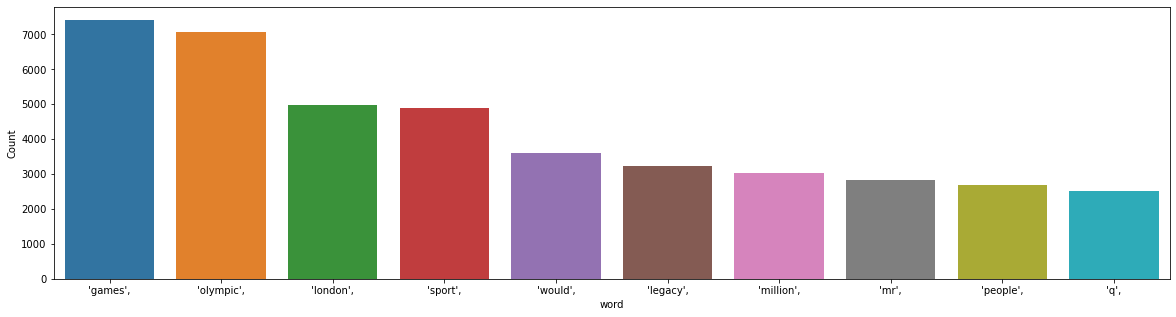

In [31]:
#Reomve stop words
stop_words = stopwords.words('english')
df[col] = [ [token for token in doc if not token in stop_words] for doc in df[col] ]
print('Tokens number after removing stop words: %d'% (len(Dictionary(df[col]))))
freq_words(df[col],10) 

Tokens number after removing short words: 18367


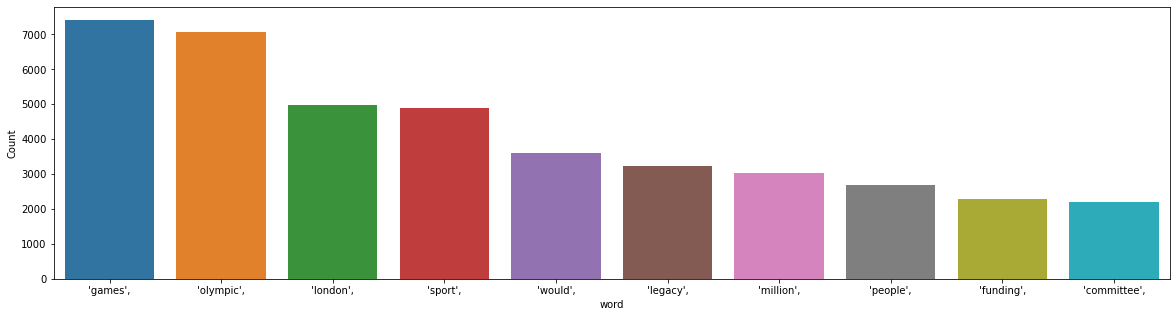

In [32]:
#Remove short words (length< min_len)
df[col] = [ [token for token in doc if not len(token) < min_len] for doc in df[col] ]
print('Tokens number after removing short words: %d'% (len(Dictionary(df[col]))))
freq_words(df[col],10) 

<ipython-input-33-0b0b66bce8a6>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = lemmatize_sentence(df[col][i])


Lemmatization with POS tags...
Tokens number after lemmatization: 15732


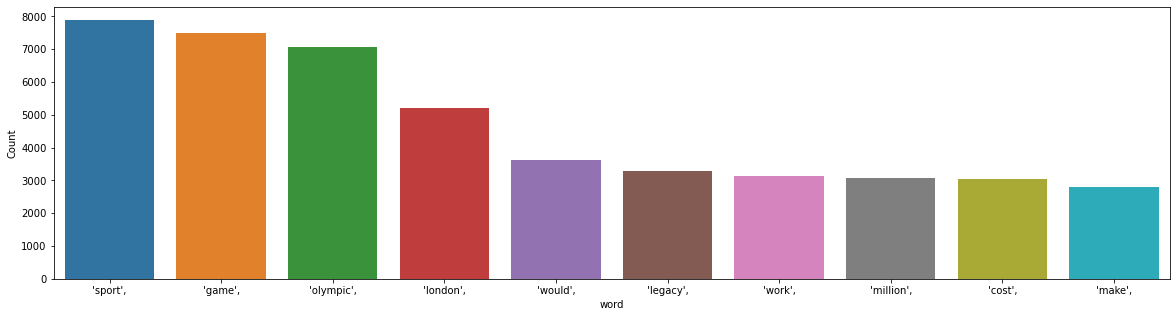

In [33]:
# Corpus Lemmatization
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet


def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
def lemmatize_sentence(sentence):
    res = []
    lemmatizer = WordNetLemmatizer()
    for word, pos in pos_tag(sentence):
        wordnet_pos = get_wordnet_pos(pos) or wordnet.NOUN
        res.append(lemmatizer.lemmatize(word, pos=wordnet_pos))

    return res

if lemmatization == 1:
    for i in range (len(df)):
        df[col][i] = lemmatize_sentence(df[col][i])
    print('Lemmatization with POS tags...')

if lemmatization == 2:
    lemmatizer = WordNetLemmatizer()
    df[col] = [ [lemmatizer.lemmatize(token) for token in doc ] for doc in df[col] ]
    print('Lemmatization without POS tags...')

if lemmatization == 0:
    print('Cancel lemmatization...')

print('Tokens number after lemmatization: %d'% (len(Dictionary(df[col]))))
freq_words(df[col],10) 

In [34]:
#Remove all punctuations
#punctuation_string = string.punctuation
#for j in range (len(df)):
#    for i in punctuation_string:
#        df[col][j] = str(df[col][j]).replace(i, '')

Tokens number after adding bigram: 16742


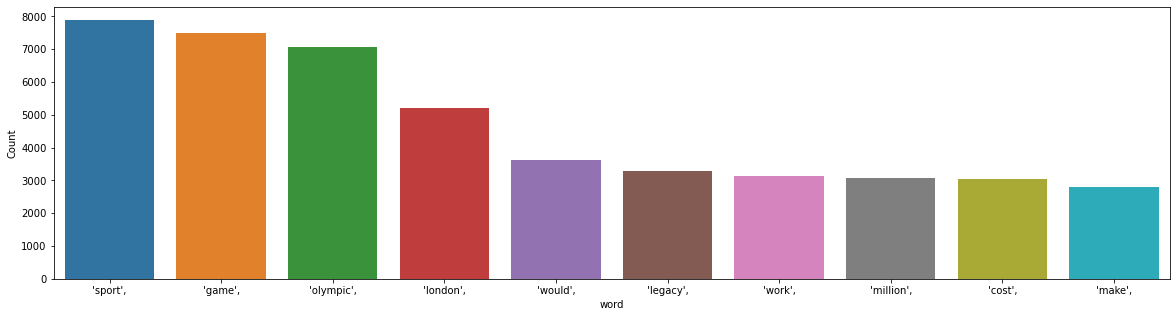

In [35]:
# Make bigram
bigrams_phases = Phrases(df[col], min_count = 10)
for i in range(len(df[col])):
    for token in bigrams_phases[df[col][i]]:
        if '_' in token:
            df[col][i].append(token)            

print('Tokens number after adding bigram: %d'% (len(Dictionary(df[col]))))
freq_words(df[col],10) 

## 1.5 The LDA Model Building

In [39]:
# Build a dictionary
LOdict = Dictionary(df[col])

print('Tokens number after creating dictionary: %d'% (len(LOdict)))

Tokens number after creating dictionary: 16742


In [40]:
#Remove  words occur less than no_below documents and more then no_above/documents
LOdict.filter_extremes(no_below = no_below, no_above = no_above)

print('Tokens number after tf-idf: %d'% (len(LOdict)))

Tokens number after tf-idf: 9316


In [41]:
# Create bag of word for corpus
LOcorpus = [LOdict.doc2bow(doc) for doc in df[col]]

In [42]:
#Mapping from word IDs to words. It is used to determine the vocabulary size, as well as for debugging and topic printing.
id2word = LOdict 

In [214]:
num_topics =  12

In [215]:
# Buila a LDA model for LONDON OLYPLMICS
LOldamodel = LdaModel(
    corpus = LOcorpus,
    id2word = id2word,
    chunksize = chunksize,
    alpha = alpha,
    eta = eta,
    iterations = iterations,
    num_topics = num_topics,
    passes = num_passes,
    eval_every = eval_every,
    random_state = random_state
)
print('LDA model training complete with number of topics: ', num_topics)

LDA model training complete with number of topics:  12


In [337]:
LOldamodel.print_topics()

[(0,
  '0.020*"legacy" + 0.015*"borough" + 0.015*"benefit" + 0.014*"park" + 0.013*"host" + 0.011*"local" + 0.011*"area" + 0.008*"hackney" + 0.008*"opportunity" + 0.008*"community"'),
 (1,
  '0.024*"stadium" + 0.018*"would" + 0.013*"wembley" + 0.013*"city" + 0.013*"transport" + 0.013*"cost" + 0.012*"athletics" + 0.010*"arup" + 0.009*"report" + 0.009*"village"'),
 (2,
  '0.031*"performance" + 0.031*"medal" + 0.028*"athlete" + 0.020*"body" + 0.017*"paralympic" + 0.016*"success" + 0.016*"british" + 0.015*"funding" + 0.014*"team" + 0.014*"govern"'),
 (3,
  '0.012*"jonathan" + 0.012*"million" + 0.009*"cost" + 0.008*"security" + 0.007*"report" + 0.007*"would" + 0.007*"public" + 0.007*"people" + 0.006*"think" + 0.006*"chair"'),
 (4,
  '0.017*"would" + 0.013*"people" + 0.013*"go" + 0.011*"come" + 0.011*"think" + 0.010*"work" + 0.007*"park" + 0.007*"take" + 0.007*"ainsworth" + 0.007*"make"'),
 (5,
  '0.008*"legacy" + 0.007*"would" + 0.006*"work" + 0.006*"make" + 0.005*"people" + 0.005*"million" 

In [167]:
#Compute Coherence Score
coherence_model_lda = CoherenceModel(model = LOldamodel, texts = df[col], dictionary = LOdict, coherence=coherence_type)
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score ', coherence_type,'=', coherence_lda, ' with number of topics=', num_topics)

Coherence Score  c_v = 0.43237177903848945  with number of topics= 4


C:\ProgramData\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\ProgramData\Anaconda3\lib\site-packages\xlrd\xlsx.py:312: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\ProgramData\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


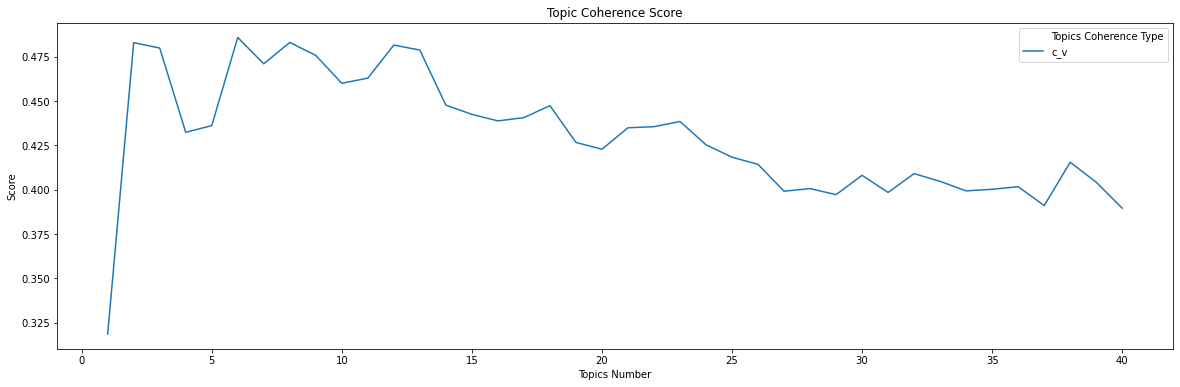

In [213]:
tc_score = pd.DataFrame(pd.read_excel("document topic coherence.xlsx"))
tc = sns.lineplot(x = 'Topics Number', y = 'Score', hue = 'Topics Coherence Type', data = tc_score)
tc.set(title = 'Topic Coherence Score')
tc.figure.set_size_inches(20,6)
#plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40])

## 2. The LDA Model Visulization

### 2.1 Packages Importing

In [373]:
import pyLDAvis
import pyLDAvis.gensim_models as gensim_models

### 2.2 Visulization

In [374]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(LOldamodel, LOcorpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.008302  0.040284       1        1  19.995365
6     -0.012703  0.003550       2        1  17.111956
10     0.108073  0.092982       3        1  12.894159
11     0.046205 -0.195345       4        1  10.163590
3      0.131211 -0.018756       5        1   8.876694
7      0.092920  0.096679       6        1   7.653725
9      0.025614 -0.191039       7        1   7.529700
0     -0.067025  0.030103       8        1   4.396773
8     -0.175579  0.057304       9        1   3.583587
4      0.130147  0.139065      10        1   2.811321
2     -0.259971  0.035580      11        1   2.634382
1     -0.010589 -0.090410      12        1   2.348746, topic_info=               Term         Freq        Total Category  logprob  loglift
70          athlete  1150.000000  1150.000000  Default  30.0000  30.0000
896           would  3601.000000  3601.000000  Default  29.0000  29.0000
1584    performance   918.000000   918.000000  Default  28.0000  28.0000
1390           cost  3068.000000  3068.000000  Default  27.0000  27.0000
1870          medal   804.000000   804.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
167       committee    91.733711  2437.442090  Topic12  -4.8667   0.4715
28             also    79.948797  1837.650905  Topic12  -5.0042   0.6164
356      government    82.819230  2229.456254  Topic12  -4.9689   0.4584
1000        england    64.680094   809.868921  Topic12  -5.2161   1.2239
1171  sport_england    60.249328   549.717607  Topic12  -5.2871   1.5404

[1023 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
5209      1  0.265555       academy
5209      2  0.186872       academy
5209      3  0.068848       academy
5209      5  0.039342       academy
5209      6  0.019671       academy
...     ...       ...           ...
1994     11  0.012875  young_people
903       5  0.153652         youre
903       6  0.793871         youre
903       8  0.025609         youre
903      10  0.025609         youre

[3598 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 11, 12, 4, 8, 10, 1, 9, 5, 3, 2])

## 3 Corpus Classification

### 3.1 PARS Corpus Reading 

In [230]:
pf = pd.read_csv("NewChunkAll-STRIP-ASCII.csv", header = None)

In [231]:
pf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23147 entries, 0 to 23146
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       23147 non-null  int64 
 1   1       23147 non-null  object
 2   2       23147 non-null  object
 3   3       383 non-null    object
 4   4       193 non-null    object
 5   5       7 non-null      object
 6   6       7 non-null      object
 7   7       1 non-null      object
 8   8       1 non-null      object
dtypes: int64(1), object(8)
memory usage: 1.6+ MB


### 3.2 PARS Corpus Processing

Document number: 23147


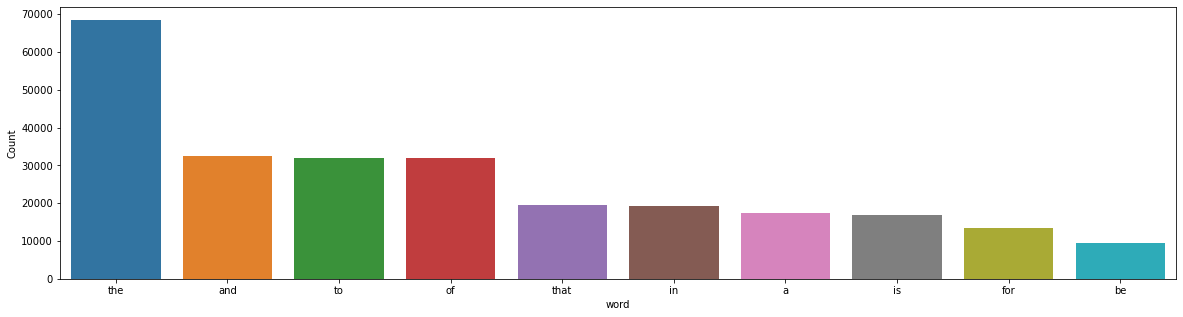

In [232]:
print('Document number: %d'% (len(pf[col])))
freq_words(pf[2],10) 

<ipython-input-233-3a225dea0519>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pf[col][i] = pf[col][i].lower()
<ipython-input-233-3a225dea0519>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pf[col][i] = tokenizer.tokenize(pf[col][i])


Tokens number: 19326


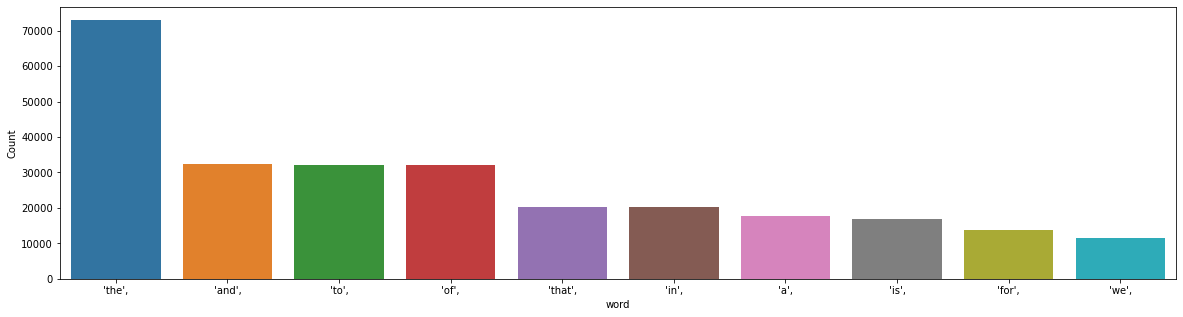

In [233]:
#Tokenize the corpus 
tokenizer = RegexpTokenizer(r'\w+')
for i in range (len(pf)):
    pf[col][i] = pf[col][i].lower()
    pf[col][i] = tokenizer.tokenize(pf[col][i])

print('Tokens number: %d'% (len(Dictionary(pf[col]))))
freq_words(pf[col],10) 

Tokens number after removing number: 19133


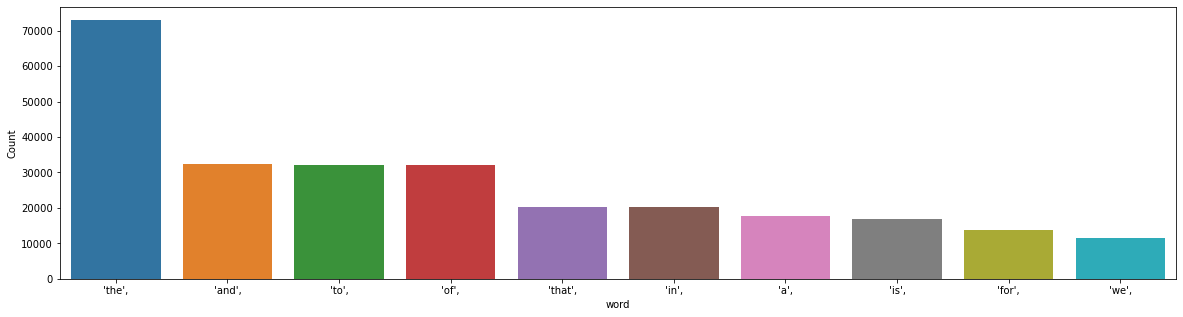

In [234]:
#Remove the number
pf[col] = [ [token for token in doc if not token.isnumeric()] for doc in pf[col]]

print('Tokens number after removing number: %d'% (len(Dictionary(pf[col]))))
freq_words(pf[col],10) 

Tokens number after removing stop words: 18997


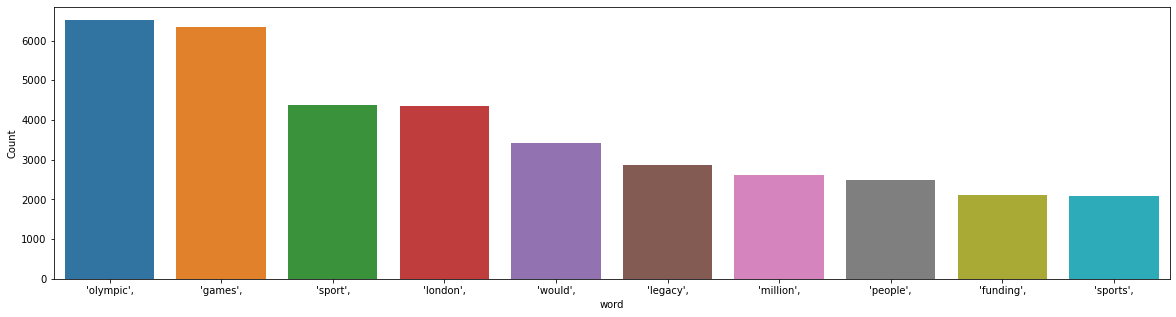

In [235]:
#Reomve stop words
stop_words = stopwords.words('english')
pf[col] = [ [token for token in doc if not token in stop_words] for doc in pf[col] ]
print('Tokens number after removing stop words: %d'% (len(Dictionary(pf[col]))))
freq_words(pf[col],10) 

Tokens number after removing short words: 18261


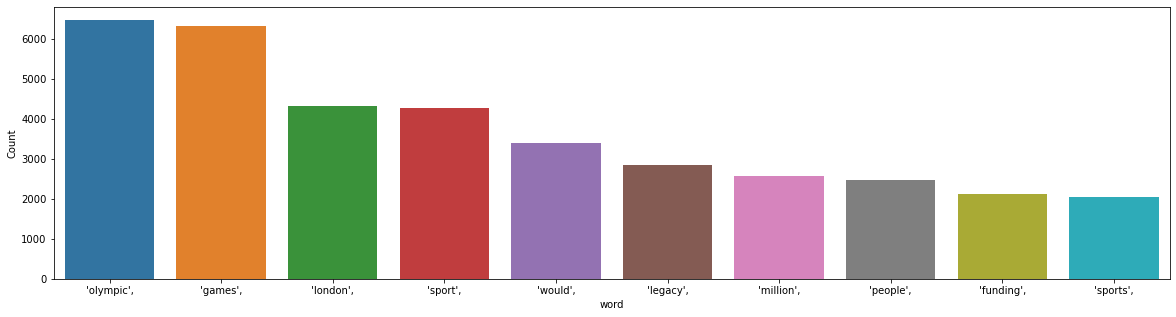

In [236]:
#Remove short words (length< min_len)
pf[col] = [ [token for token in doc if not len(token) < min_len] for doc in pf[col] ]
print('Tokens number after removing short words: %d'% (len(Dictionary(pf[col]))))
freq_words(pf[col],10) 

<ipython-input-237-036ce53c5e95>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pf[col][i] = lemmatize_sentence(pf[col][i])


Lemmatization with POS tags...
Tokens number after lemmatization: 15631


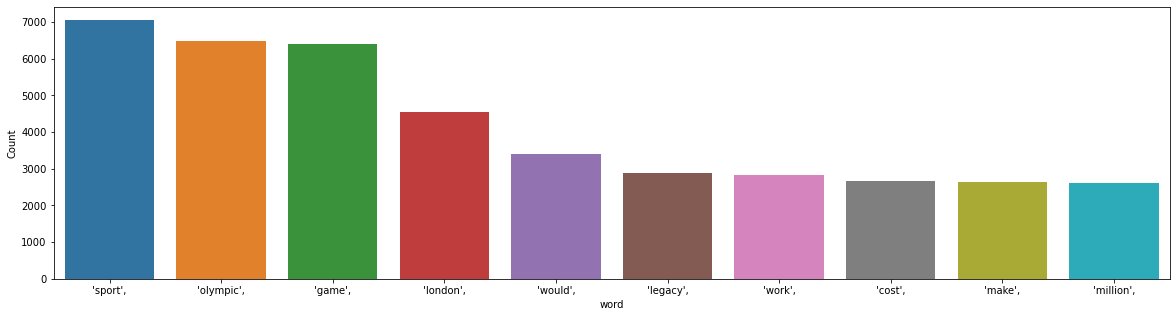

In [237]:
# Corpus Lemmatization
if lemmatization == 1:
    for i in range (len(pf)):
        pf[col][i] = lemmatize_sentence(pf[col][i])
    print('Lemmatization with POS tags...')

if lemmatization == 2:
    lemmatizer = WordNetLemmatizer()
    pf[col] = [ [lemmatizer.lemmatize(token) for token in doc ] for doc in pf[col] ]
    print('Lemmatization without POS tags...')

if lemmatization == 0:
    print('Cancel lemmatization...')

print('Tokens number after lemmatization: %d'% (len(Dictionary(pf[col]))))
freq_words(pf[col],10) 

Tokens number after adding bigram: 16581


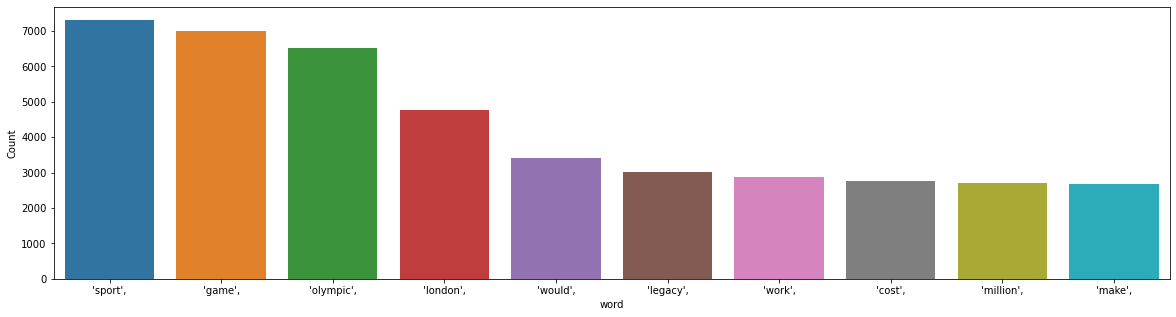

In [448]:
# Make bigram
P_bigrams_phases = Phrases(pf[col], min_count = 10)
for i in range(len(pf[col])):
    for token in P_bigrams_phases[pf[col][i]]:
        if '_' in token:
            pf[col][i].append(token)            

print('Tokens number after adding bigram: %d'% (len(Dictionary(pf[col]))))
freq_words(pf[col],10) 

### 3.3 Classify PARAS

### 3.3.1 Parameter Setting

In [449]:
minimum_probability = 0.05 #Topics with an assigned probability lower than this threshold will be discarded.
rank = 10                          #Set rank of for for topic 
topic = 1                           #Topic filter of the Highest ranked paragraphs

### 3.3.2 PARS Classification

In [450]:
Pcorpus = [LOdict.doc2bow(doc) for doc in pf[col]]
#Make the Dataframe of the highest probable topics of each paragraph
MTopics =  list()
for i in LOldamodel.get_document_topics(Pcorpus, per_word_topics=False)[:]:
    listj=[]
    for j in i:
        listj.append(j[1])
    bz=listj.index(max(listj))
#    print(bz,listj[bz], i)
    MTopics.append([bz, listj[bz]])

MTopics = pd.DataFrame(MTopics)

classifer_document = pd.concat([pf.iloc[:,0:2],MTopics],axis=1)
classifer_document.columns = ["Paragraph Number","Souce Filename","The Highest Probable Topic", "Probability"]

In [451]:
#1.	Highest N ranked paragraphs for topic K
classifer_document[classifer_document['The Highest Probable Topic']==topic].nlargest(rank, 'Probability')

,Paragraph Number,Souce Filename,The Highest Probable Topic,Probability
5227,5228,Oly-Raw-New-Chunks/NewChunk3/PAC_-_Risk_assess...,1,0.702656
3801,3802,Oly-Raw-New-Chunks/NewChunk3/NAO_Budget_for_20...,1,0.679386
222,228,Oly-Raw-New-Chunks/NewChunk1/Jan_2003_-_Qs_140...,1,0.659199
221,226,Oly-Raw-New-Chunks/NewChunk1/Jan_2003_-_Qs_140...,1,0.652932
14288,14290,Oly-Raw-New-Chunks/NewChunk5a/NAO_Preparations...,1,0.647678
2157,2158,Oly-Raw-New-Chunks/NewChunk2/Qs_180-199.txt,1,0.645345
354,357,Oly-Raw-New-Chunks/NewChunk1/Jan_2003_-_Qs_200...,1,0.642257
212,213,Oly-Raw-New-Chunks/NewChunk1/Jan_2003_-_Qs_140...,1,0.639819
19593,19600,Oly-Raw-New-Chunks/NewChunk7/Oral_evidence_Dec...,1,0.639800
164,171,Oly-Raw-New-Chunks/NewChunk1/Jan_2003_-_Qs_100...,1,0.636134


In [455]:
#2.	Highest N ranked paragraphs overall
classifer_document.nlargest(rank, 'Probability')

,Paragraph Number,Souce Filename,The Highest Probable Topic,Probability
21575,21594,Oly-Raw-New-Chunks/NewChunk7/Preparations_for_...,0,0.812340
21568,21585,Oly-Raw-New-Chunks/NewChunk7/Preparations_for_...,0,0.792063
21533,21540,Oly-Raw-New-Chunks/NewChunk7/Preparations_for_...,0,0.785714
14257,14258,Oly-Raw-New-Chunks/NewChunk5a/NAO_Preparations...,0,0.783114
16063,16064,Oly-Raw-New-Chunks/NewChunk6/NAO_Preparations_...,0,0.767374
21562,21578,Oly-Raw-New-Chunks/NewChunk7/Preparations_for_...,0,0.764555
21555,21569,Oly-Raw-New-Chunks/NewChunk7/Preparations_for_...,0,0.763321
21541,21551,Oly-Raw-New-Chunks/NewChunk7/Preparations_for_...,0,0.756136
21569,21587,Oly-Raw-New-Chunks/NewChunk7/Preparations_for_...,0,0.755177
21513,21515,Oly-Raw-New-Chunks/NewChunk7/Preparations_for_...,0,0.744863


In [456]:
#3.	Highest N ranked paragraphs from each topic K
classifer_document.groupby(by='The Highest Probable Topic').apply(lambda x:x.nlargest(rank, 'Probability'))

Paragraph Number  \
The Highest Probable Topic                           
0                          21575             21594   
                           21568             21585   
                           21533             21540   
                           14257             14258   
                           16063             16064   
...                                            ...   
11                         4464               4465   
                           5215               5216   
                           22255             22258   
                           3686               3687   
                           5361               5362   

                                                                     Souce Filename  \
The Highest Probable Topic                                                            
0                          21575  Oly-Raw-New-Chunks/NewChunk7/Preparations_for_...   
                           21568  Oly-Raw-New-Chunks/NewChunk7/Preparations_for_...   
                           21533  Oly-Raw-New-Chunks/NewChunk7/Preparations_for_...   
                           14257  Oly-Raw-New-Chunks/NewChunk5a/NAO_Preparations...   
                           16063  Oly-Raw-New-Chunks/NewChunk6/NAO_Preparations_...   
...                                                                             ...   
11                         4464   Oly-Raw-New-Chunks/NewChunk3/NAO_Risk_assessme...   
                           5215   Oly-Raw-New-Chunks/NewChunk3/PAC_-_Risk_assess...   
                           22255  Oly-Raw-New-Chunks/NewChunk8/NAO_report_Post_G...   
                           3686   Oly-Raw-New-Chunks/NewChunk3/NAO_Budget_for_20...   
                           5361   Oly-Raw-New-Chunks/NewChunk3/PAC_-_Risk_assess...   

                                  The Highest Probable Topic  Probability  
The Highest Probable Topic                                                 
0                          21575                           0     0.812340  
                           21568                           0     0.792063  
                           21533                           0     0.785714  
                           14257                           0     0.783114  
                           16063                           0     0.767374  
...                                                      ...          ...  
11                         4464                           11     0.340220  
                           5215                           11     0.332263  
                           22255                          11     0.328974  
                           3686                           11     0.328036  
                           5361                           11     0.326150  

[120 rows x 4 columns]

In [ ]:
#4.	Highest N ranked paragraphs where the belong() function is greater than the threshold for M topics at a time
T_MTopics =  list()
for i in LOldamodel.get_document_topics(Pcorpus, minimum_probability = minimum_probability, per_word_topics=False)[:]:
    listj=[]
    for j in i:
        listj.append(j[1])
    bz=listj.index(max(listj))
#    print(bz,listj[bz], i)
    T_MTopics.append([bz, listj[bz]])

T_MTopics = pd.DataFrame(T_MTopics)

classifer_document_threshold = pd.concat([pf.iloc[:,0:2],T_MTopics],axis=1)
classifer_document_threshold.columns = ["Paragraph Number","Souce Filename","The Highest Probable Topic", "Probability"]

In [458]:
classifer_document_threshold[classifer_document_threshold['The Highest Probable Topic']==topic].nlargest(rank, 'Probability')

,Paragraph Number,Souce Filename,The Highest Probable Topic,Probability
5227,5228,Oly-Raw-New-Chunks/NewChunk3/PAC_-_Risk_assess...,1,0.702654
3801,3802,Oly-Raw-New-Chunks/NewChunk3/NAO_Budget_for_20...,1,0.679390
222,228,Oly-Raw-New-Chunks/NewChunk1/Jan_2003_-_Qs_140...,1,0.659208
221,226,Oly-Raw-New-Chunks/NewChunk1/Jan_2003_-_Qs_140...,1,0.652916
14288,14290,Oly-Raw-New-Chunks/NewChunk5a/NAO_Preparations...,1,0.647675
2157,2158,Oly-Raw-New-Chunks/NewChunk2/Qs_180-199.txt,1,0.645339
354,357,Oly-Raw-New-Chunks/NewChunk1/Jan_2003_-_Qs_200...,1,0.642260
212,213,Oly-Raw-New-Chunks/NewChunk1/Jan_2003_-_Qs_140...,1,0.639814
19593,19600,Oly-Raw-New-Chunks/NewChunk7/Oral_evidence_Dec...,1,0.639805
164,171,Oly-Raw-New-Chunks/NewChunk1/Jan_2003_-_Qs_100...,1,0.636132
